# Seizure Detection and Prediction by Parallel Memristive Convolutional Neural Networks
<br>


In [1]:
import numpy as np
import statistics
import pyedflib
# import mne

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

from IPython.display import display, Markdown  #display(Markdown("# Hello World!"))


In [2]:
# %matplotlib notebook
plt.style.use('ggplot')

In [3]:
display(Markdown('[All signals were sampled at 256 samples per second with 16-bit resolution]\
(https://www.researchgate.net/figure/23-scalp-EEG-channels-in-the-CHB-MIT-recordings_tbl1_356885415)'))

# File Name: chb07_13.edf
# File Start Time: 11:46:29
# File End Time: 12:48:35
# Number of Seizures in File: 1
# Seizure 1 Start Time: 3285 seconds
# Seizure 1 End Time: 3381 seconds

sample_rate = 256

[All signals were sampled at 256 samples per second with 16-bit resolution](https://www.researchgate.net/figure/23-scalp-EEG-channels-in-the-CHB-MIT-recordings_tbl1_356885415)

In [4]:
def readedf(path):
    f = pyedflib.EdfReader(path)
    n = f.signals_in_file
    signal_labels = f.getSignalLabels()
    sigbufs = np.zeros((n, f.getNSamples()[0]))
    for i in np.arange(n):
        sigbufs[i,:] = f.readSignal(i)
    return sigbufs

In [5]:
path = './chb07_13.edf'
chb07_13 = readedf(path)
path = './chb07_02.edf'
chb07_02 = readedf(path)
chb07_13.shape, chb07_02.shape

((23, 953856), (23, 3686400))

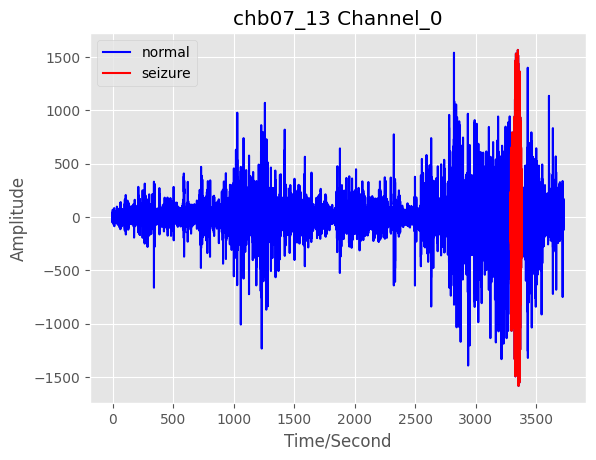

In [6]:
# File Name: chb07_13.edf
# File Start Time: 11:46:29
# File End Time: 12:48:35
# Number of Seizures in File: 1
# Seizure 1 Start Time: 3285 seconds
# Seizure 1 End Time: 3381 seconds

timeline = np.arange(0,np.size(chb07_13,axis=1)/sample_rate, 1/sample_rate) # define the time axis
seizure_start = np.where(timeline==3285)[0]  # Seizure START
seizure_end = np.where(timeline==3381)[0]    # Seizure END

plt.figure()
plt.title('chb07_13 Channel_0')
plt.plot(timeline, chb07_13[1,:],'b', label='normal')
plt.plot(timeline[int(seizure_start):int(seizure_end)],chb07_13[1,int(seizure_start):int(seizure_end)],'r', label='seizure')
plt.xlabel('Time/Second')
plt.ylabel('Amplitude')
plt.legend()

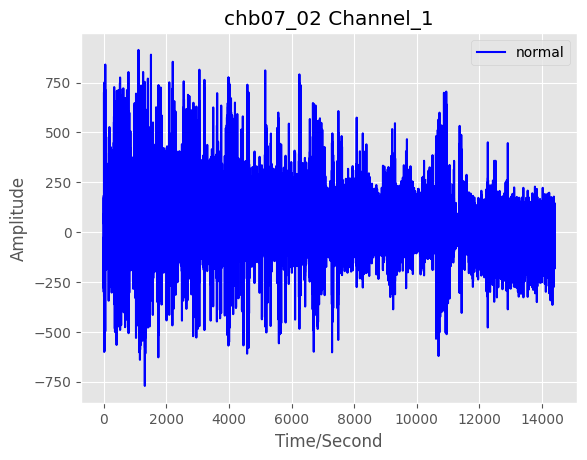

In [7]:
# File Name: chb07_02.edf
# File Start Time: 21:00:13
# File End Time: 25:00:13
# Number of Seizures in File: 0
chb0702_TL = np.arange(0,np.size(chb07_02,axis=1)/sample_rate,1/sample_rate)
plt.figure()
plt.title('chb07_02 Channel_1')
plt.plot(chb0702_TL, chb07_02[0,:],'b', label='normal')
plt.xlabel('Time/Second')
plt.ylabel('Amplitude')
plt.legend()

## Test pre_ictal signal

In [8]:
pre_ictal = chb07_13[:,211200:825600]
pre_ict_TL = np.arange(825,3225,1/sample_rate)

Text(0.5, 1.0, 'Pre-ictal signal')

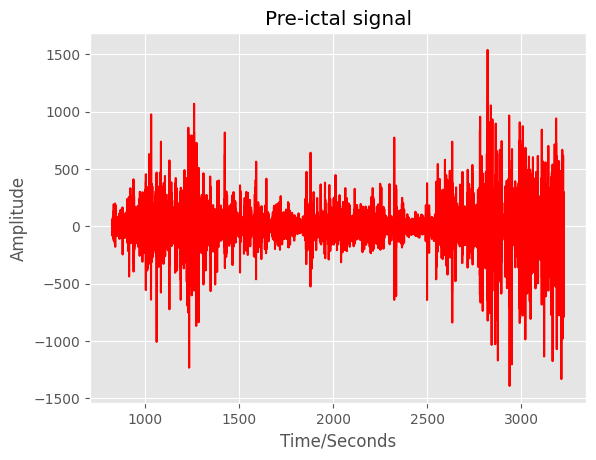

In [9]:
plt.figure()
plt.plot(pre_ict_TL, pre_ictal[1,:],c='r')
plt.xlabel('Time/Seconds')
plt.ylabel('Amplitude')
plt.title('Pre-ictal signal')

Text(0.5, 1.0, 'inter-ictal signal')

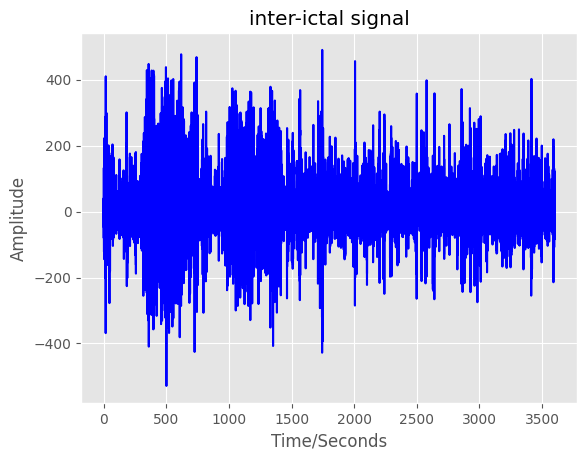

In [10]:
inter_ictal = chb07_02[:,0:60*60*sample_rate]                       # 60 min = 60 * 60 seconds = 60*60*sample_rate points
inter_ict_TL = np.arange(0,3600,1/sample_rate)

# plot figure
plt.figure()
plt.plot(inter_ict_TL, inter_ictal[1,:],c='b')
plt.xlabel('Time/Seconds')
plt.ylabel('Amplitude')
plt.title('inter-ictal signal')

## Mean

In [11]:
def feat_mean(array):
    return np.mean(array)

## Variance

In [12]:
def feat_variance(array):
    return np.var(array, axis=0)

## Skewness

In [13]:
def feat_skewness(array):
    skewness = np.mean((array - np.mean(array))**3) / np.std(array)**3
    return skewness

## Kurtosis

In [14]:
def feat_kurtosis(array):
    kurtosis = np.mean((array - np.mean(array))**4) / np.std(array)**4
    return kurtosis

## Coefficient of variation

In [15]:
def feat_cov(array):
    CoV = (np.std(array)/np.mean(array))
    return CoV

## Median absolute deviation

In [16]:
def feat_mad(array):
    median = np.median(array)
    abs_deviation = np.abs(array-median)
    mad = np.median(abs_deviation)
    return mad

## Root mean square amplitude

In [17]:
def feat_rms(array):
    rms_amplitude = np.sqrt(np.mean(np.square(array)))
    return rms_amplitude

## Shannon entropy

In [18]:
def feat_shannon_entropy(sequence):
    uniqw, inverse = np.unique(sequence, return_inverse=True)
    event_counts = np.bincount(inverse)

    # Calculate probabilities
    total_events = len(sequence)
    event_probabilities = event_counts / total_events

    # Calculate Shannon entropy
    entropy = -np.sum(event_probabilities * np.log2(event_probabilities))
    return entropy

## Features calculate

In [19]:
def get_features(array):
    all_features = np.zeros((1,8))
    all_features[0,0] = feat_mean(array)
    all_features[0,1] = feat_variance(array)
    all_features[0,2] = feat_skewness(array)
    all_features[0,3] = feat_kurtosis(array)
    all_features[0,4] = feat_cov(array)
    all_features[0,5] = feat_mad(array)
    all_features[0,6] = feat_rms(array)
    all_features[0,7] = feat_shannon_entropy(array)
    return all_features

__________

In [20]:
channel_feat_chb0713 = np.zeros((np.size(pre_ictal,axis=0), 8))    # 23 channel & 8 features
for i in range(np.size(pre_ictal,axis=0)):
    channel_feat_chb0713[i,:] = get_features(pre_ictal[i,:])          # pre-ictal features
    
channel_feat_chb0702 = np.zeros((np.size(inter_ictal,axis=0), 8))    # 23 channel & 8 features
for i in range(np.size(inter_ictal,axis=0)):
    channel_feat_chb0702[i,:] = get_features(inter_ictal[i,:])          # inter-ictal features

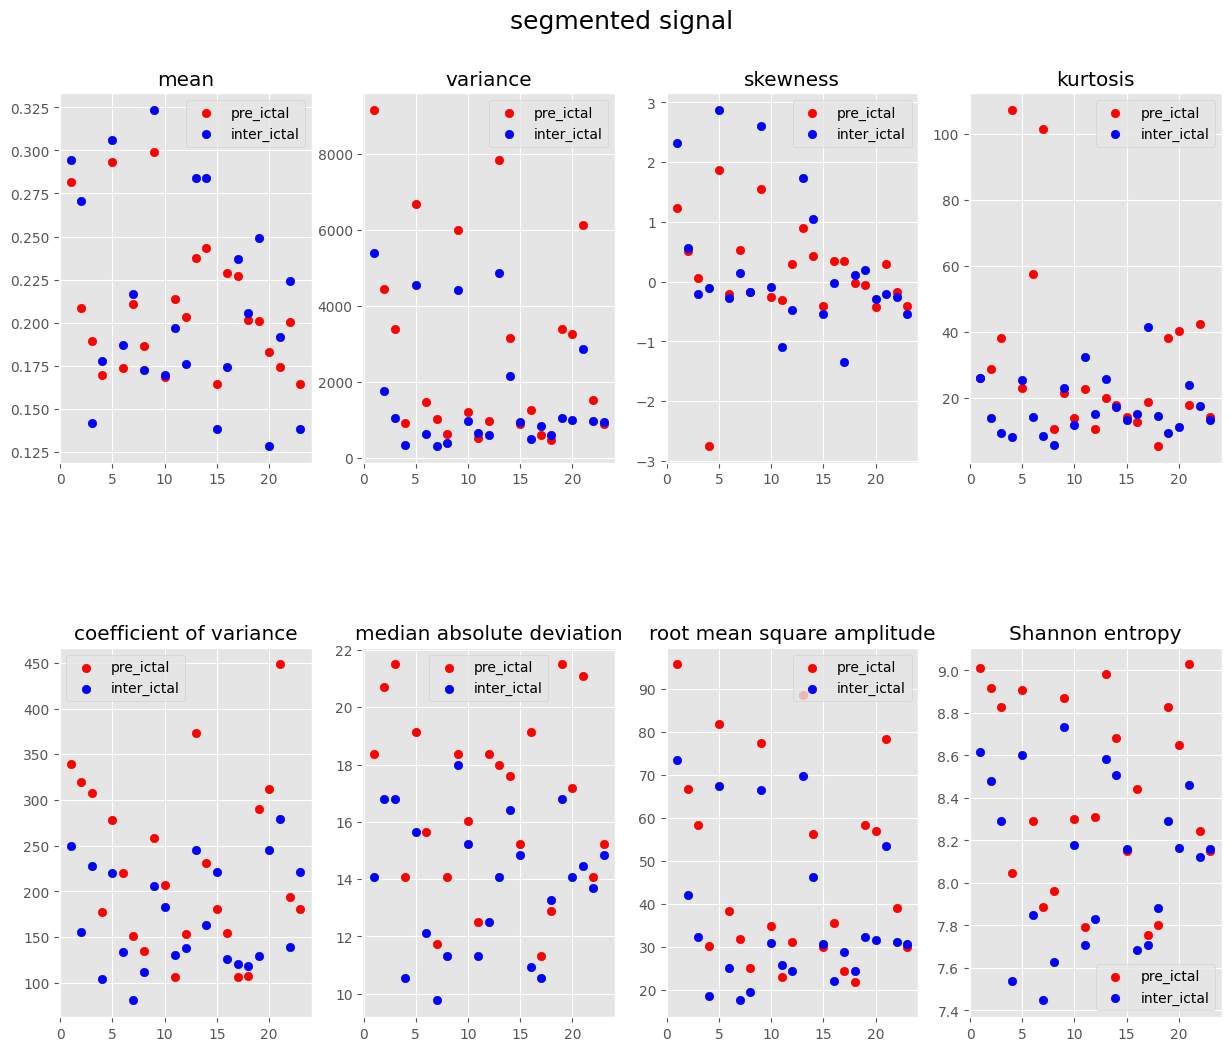

In [21]:
# Create format of subplot
features_title = ['mean', 'variance','skewness', 'kurtosis', 'coefficient of variance',
                 'median absolute deviation', 'root mean square amplitude', 'Shannon entropy' ]
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("segmented signal", fontsize=18, y=0.95)
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.title(features_title[i])
    plt.scatter(np.arange(1.0,24.0,1.0),channel_feat_chb0713[:,i],c='r',label='pre_ictal')
    plt.scatter(np.arange(1.0,24.0,1.0),channel_feat_chb0702[:,i],c='b',label='inter_ictal')
    plt.legend()

In [29]:
np.mean(channel_feat_chb0702,axis=0)

(8,)

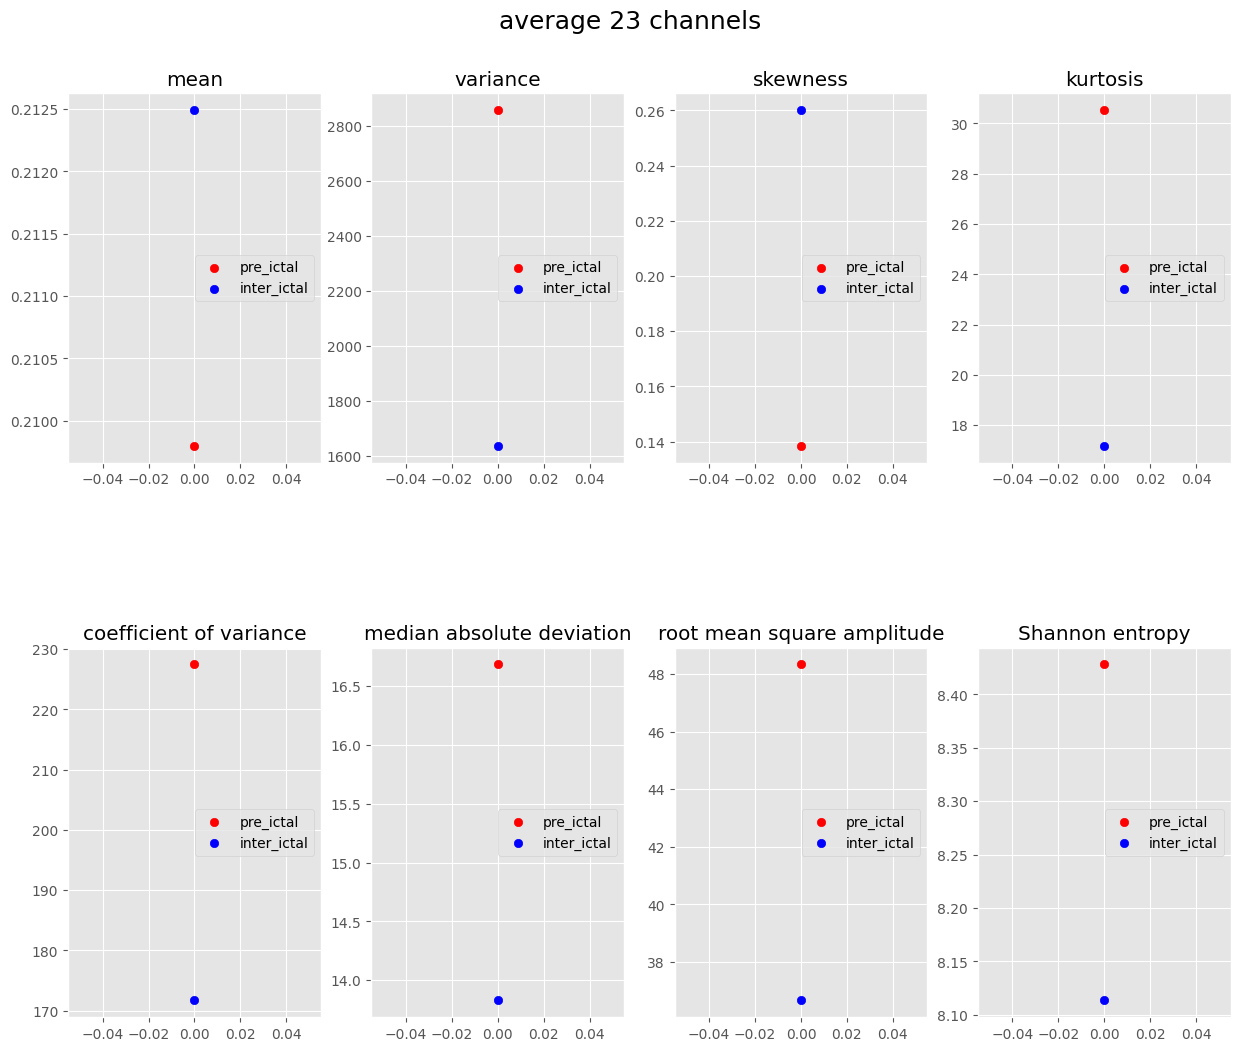

In [33]:
# Create format of subplot
features_title = ['mean', 'variance','skewness', 'kurtosis', 'coefficient of variance',
                 'median absolute deviation', 'root mean square amplitude', 'Shannon entropy' ]
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("average 23 channels", fontsize=18, y=0.95)
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.title(features_title[i])
    plt.scatter(np.arange(1),np.mean(channel_feat_chb0713[:,i],axis=0),c='r',label='pre_ictal')
    plt.scatter(np.arange(1),np.mean(channel_feat_chb0702[:,i],axis=0),c='b',label='inter_ictal')
    plt.legend(loc='center right')